## **1. Installation and imports**

In [1]:
import os
import sys

import pickle
import torch
from transformers import BertTokenizer, BertForSequenceClassification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Imports for the probing model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

# Add project root
#project_root = "/home/fantoni/patent-sentence-classification"
#sys.path.append(project_root)
from src.config import load_config
from src.model import PatentSentenceClassifier

<jemalloc>: Unsupported system page size


## **1. Loading the model**

In [2]:
# Load Config
cfg = load_config('config.yaml')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
base_model = BertForSequenceClassification.from_pretrained(cfg.model.name, num_labels=cfg.model.num_lables, output_hidden_states=True)
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
checkpoint_path = '/home/fantoni/patent-sentence-classification/models/best-checkpoint.ckpt'
loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)
print('\nModel loaded succesfully.')

Using device: cpu


/home/fantoni/miniconda3/envs/patent-sentence-classification/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.

Model loaded succesfully.


## **2. Dataset**

In [3]:
# Import test set
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')
print(f"Tot. number of sentences: {len(df)}")
df.head(10)

Tot. number of sentences: 600


,sent_id,sent,sent_tag,sent_class
0,250614,The rigid foam layer 50 is typically selected ...,STR,1
1,1894531,The bracket 80 is affixed to the troffer shelf...,MIX,2
2,1620340,figure 5 is a diagram illustrating an exemplar...,STR,1
3,1846361,"In one exemplary implementation, the subject m...",FUN,0
4,276595,The motion sickness control system may include...,STR,1
5,357834,Some embodiments of the invention include a ph...,STR,1
6,2674079,Multi-role amplifier 900 provides an RCA pre-a...,FUN,0
7,1847887,The hook region 310 may include two or more cu...,STR,1
8,384624,A foam product based on epoxidized vegetable o...,STR,1
9,1848061,A firth object of the present invention is to ...,STR,1


## **3. Extraction of the internal representations**


In [5]:
embeddings = []
sent_ids = []
sentences = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    sent_id = row['sent_id']
    sent = row['sent']
    inputs = bert_tokenizer(sent, truncation=True, padding=True, max_length=cfg.model.max_length, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
      outputs = loaded_model(**inputs)
      embeddings.append(outputs["hidden_states"])
      sent_ids.append(sent_id)
      sentences.append(sent)

# Saving the representations 
with open("./data/probing/patent_sentence_classifier_representations.pkl", "wb") as fOut:
   pickle.dump({'sent_ids': sent_ids, 'sentences': sentences, 'embeddings': embeddings}, fOut)

### **3.1. Exploring Model output**

In [6]:
# Load the internal representation from the pickle file
with open("./data/probing/patent_sentence_classifier_representations.pkl", "rb") as fIn:
    data = pickle.load(fIn)

# Extracting the sentences and embeddings from the data
sentences = data['sentences']
embeddings = data['embeddings']
sent_ids = data['sent_ids']

# Sample sentence selection (e.g., index 300)
idx = 0
sample_sent = sentences[idx]
sample_embed = embeddings[idx]

# Visualize the output of the tokenization process on the sample sentence extracted from the dataset
inputs = bert_tokenizer(sample_sent, truncation=True, padding=True, max_length=cfg.model.max_length)
sample_tokens = bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'])
print("Tokens:", sample_tokens)
print()

# Number of layers of the model
n_layers = len(sample_embed)
print("Num. of layers:", n_layers)
print()

# Word representations of a specific selected layer
layer = 12
hidden_state = sample_embed[layer]
print(hidden_state)
print()

# Visualize the dimension of the 'hidden_state' object (i.e. number of sentences * number of tokens * number of hidden units)
print("Tensor dimension:", hidden_state.shape)
print()

# Visualize the embedding of a specific token of the selected sample sentence
word_embeddings = {k:v for k, v in zip(sample_tokens, hidden_state[0])}
word = "rigid"
print(word_embeddings[word])

Tokens: ['[CLS]', 'the', 'rigid', 'foam', 'layer', '50', 'is', 'typically', 'selected', 'from', 'the', 'group', 'of', 'polyurethane', 'foam', '##s', ',', 'poly', '##ure', '##a', 'foam', '##s', ',', 'and', 'combinations', 'thereof', '.', '[SEP]']

Num. of layers: 25

tensor([[[-1.2254e+00, -7.3113e-01, -1.1376e-01,  ..., -8.1394e-01,
           3.2103e-01,  4.8897e-01],
         [-1.0978e+00, -7.5884e-02,  3.6041e-01,  ..., -1.9457e-02,
           3.4474e-01, -4.5244e-01],
         [-2.3735e+00,  3.4584e-01,  2.0662e+00,  ..., -1.2569e+00,
          -2.5748e-01, -9.1929e-02],
         ...,
         [ 7.2475e-01, -1.4836e-02,  9.6384e-01,  ..., -2.8394e-01,
          -6.2202e-01, -8.7424e-01],
         [-1.5871e+00, -1.3779e-01, -6.9405e-01,  ..., -5.9435e-01,
           3.2638e-01, -6.0360e-03],
         [-2.1649e-02, -1.7379e-02,  2.2928e-03,  ...,  4.3678e-02,
           3.0989e-02,  8.4781e-02]]])

Tensor dimension: torch.Size([1, 28, 1024])

tensor([-2.3735,  0.3458,  2.0662,  ..., 

## **4. Extraction of the classification (probing) features**

### **4.1. Loading the dataset with the classification features**

In [7]:
# Import test set
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')
df = df.set_index("sent_id")

def count_tokens(text):
    tokenized_text = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    tokenized_text = [item.strip() for item in tokenized_text if item.strip()] # eliminates with spaces
    return len(tokenized_text)

# Add n_tokens feature for the benchmark model
df['n_tokens'] = df['sent'].apply(count_tokens)
df.head(10)

,sent,sent_tag,sent_class,n_tokens
sent_id,,,,
250614,The rigid foam layer 50 is typically selected ...,STR,1,22
1894531,The bracket 80 is affixed to the troffer shelf...,MIX,2,39
1620340,figure 5 is a diagram illustrating an exemplar...,STR,1,21
1846361,"In one exemplary implementation, the subject m...",FUN,0,41
276595,The motion sickness control system may include...,STR,1,19
357834,Some embodiments of the invention include a ph...,STR,1,26
2674079,Multi-role amplifier 900 provides an RCA pre-a...,FUN,0,20
1847887,The hook region 310 may include two or more cu...,STR,1,32
384624,A foam product based on epoxidized vegetable o...,STR,1,28


## **5. Train the probing model**

In [8]:
def probing(embeddings, df, ids, feature, layer):

  # Dataset containing only the selected linguistic feature
  df_feature = df[feature]

  X = []
  y = []
  
  for id, sentence in zip(ids, embeddings):
    embedding_layer = sentence[layer][0]

    # We extract the representation from the [CLS] token, that is the first token in each input sequence, having set 'add_special_tokens' equal to 'True' during tokenization
    cls_embedding = embedding_layer[0].tolist()

    # Access to the value of the linguistic feature 'feature' for the given sentence, based on the id
    feat = df_feature.loc[id]

    X.append(cls_embedding)
    y.append(feat)

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)

  # Save the predictions for further analysis
  df_preds = pd.DataFrame(columns=["sent_id", "y_true", "y_pred"])
  df_preds["sent_id"] = ids_test
  df_preds["y_true"] = y_test
  df_preds["y_pred"] = y_pred
  df_preds.to_csv(f'./data/probing/results_{layer}_{feature}.tsv', sep='\t', index=True)
  
  return corr, p_val

### **5.1. Baseline model**

In [9]:
def baseline(df, feature):
  # Select "n_tokens" as X for the baseline probing model
  X = df["n_tokens"].to_numpy()
  X = X.reshape(-1, 1)
  y = df[feature].to_numpy()

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
  
  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)
  
  return corr, p_val

In [ ]:
selected_features = ["n_tokens", "sent_class"]

layers = list(range(n_layers)[1:])

# Create an empty pandas DataFrame to store the probing results
results = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
for feature in selected_features:
  # Iterate over the 12 layers of the model
  for layer in layers:
    corr, p_val = probing(embeddings, df, sent_ids, feature, layer)

    # Save the score only if the correlation is statistically significant (p-value < 0.05)
    if p_val < 0.05:
      results.loc[feature][layer] = corr

  # Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  corr_baseline, p_val_baseline = baseline(df, feature)
  if p_val < 0.05:
    results.loc[feature]["Baseline"] = corr_baseline

## **6. Results visualization**

We can now look at the results that we previously stored in a DataFrame and compare with respect to the '*n_tokens*' baseline.

Since we have performed the probing tasks using representations extracted from all 12 layers of the model, we can also explore the progression across the layers, from the input (1) to the output one (12).

In [11]:
# Visualize the results memorized in the DataFrame
results

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,Baseline
n_tokens,0.858754,0.853985,0.864911,0.883629,0.849092,0.851132,0.849944,0.859308,0.79553,0.778757,...,0.662554,0.550805,0.52749,0.406922,0.371733,0.381604,0.357885,0.364407,0.292728,0.967284
sent_class,0.431118,0.42133,0.417217,0.503842,0.419823,0.419916,0.409831,0.45845,0.408743,0.364022,...,0.35512,0.340192,0.38679,0.335547,0.410412,0.382324,0.418355,0.429687,0.459043,-0.124715


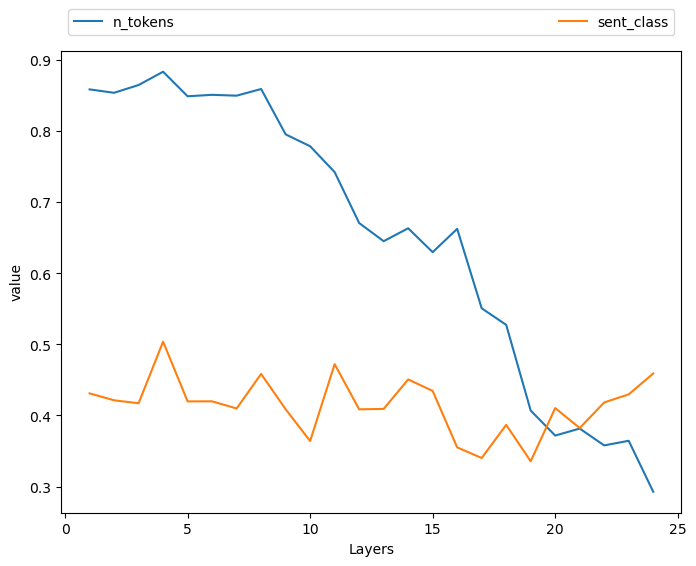

In [12]:
# Formatting the dataframe in order to be visualized as a multiline plot
results = results[layers]
results = results.T
results["Layers"] = results.index
plot_results = pd.melt(results, ["Layers"])

# Visualization with seaborn
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data=plot_results, x="Layers", y="value", hue="variable")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 1.02, 1., .102),
              loc='lower left', ncol=3, mode="expand")